In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.constants import h, c, k_B
import os
from astrodata import open as ad_open
import astropy.units as u
import pandas as pd

In [28]:
def blackbody_lambda(wavelength_nm, T):
    """ Blackbody as a function of wavelength (nm) and temperature (K).

    returns units of erg/s/cm^2/cm/Steradian (original one did, changed to return W/m^2/nm)
    """
    from scipy.constants import h, k, c
    wavelength_m = 1e-9 * wavelength_nm  # nm to m
    exponent = (h * c) / (wavelength_m * k * T)
    bb = (2 * h * c**2) / (wavelength_m**5 * (np.exp(exponent) - 1))  # W / m^2 / m
    return bb * 1e-9  # Convert from W/m^2/m to W/m^2/nm

def model(wavelength_nm, T, scale):
        return scale * blackbody_lambda(wavelength_nm, T)

# Fit function: just scaled blackbody (fit to flare-only)
# def fit_blackbody(wavelength_nm, flare_only_flux):
#     guess = [8000, 1e-11]
#     bounds = ([0, 0], [20000, np.inf])
#     popt, pcov = curve_fit(model, wavelength_nm, flare_only_flux,
#                            p0=guess, bounds=bounds, maxfev=10000)
#     perr = np.sqrt(np.diag(pcov))  # uncertainties
#     return popt, perr  # T_fit, scale_fit, and their errors
def fit_blackbody(wavelength_nm, flare_only_flux, sigma):
    guess = [8000, 1e-23]
    bounds = ([0, 0], [10000, np.inf])
    popt, pcov = curve_fit(model, wavelength_nm, flare_only_flux,
                           p0=guess, bounds=bounds, sigma=sigma,
                           absolute_sigma=True, maxfev=10000)
    perr = np.sqrt(np.diag(pcov))  # uncertainties
    return popt, perr  # T_fit, scale_fit, and their errors



/tmp/ipykernel_8947/432053465.py:8: RuntimeWarning: divide by zero encountered in divide
  exponent = (h * c) / (wavelength_m * k * T)
/tmp/ipykernel_8947/432053465.py:9: RuntimeWarning: overflow encountered in exp
  bb = (2 * h * c**2) / (wavelength_m**5 * (np.exp(exponent) - 1))  # W / m^2 / m
/tmp/ipykernel_8947/432053465.py:9: RuntimeWarning: invalid value encountered in multiply
  bb = (2 * h * c**2) / (wavelength_m**5 * (np.exp(exponent) - 1))  # W / m^2 / m


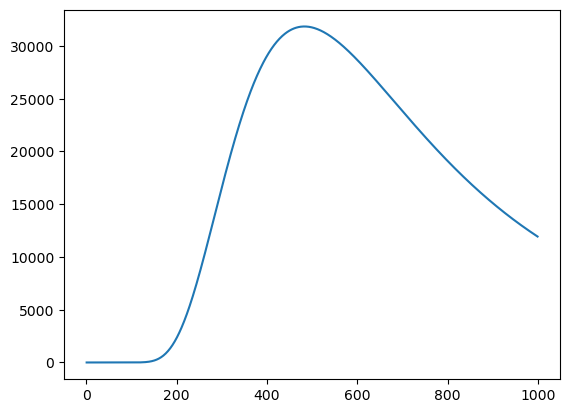

In [29]:
ff = blackbody_lambda(np.arange(0,1000), 6000)
plt.plot(np.arange(0,1000), ff)

In [30]:
files = "/home/ashto/Summer2025/TimeSeriesFiles/"
fits_files = sorted([
    os.path.join(files, f) for f in os.listdir(files) if f.endswith(".fits")])
July24 = fits_files[:16]
July29 = fits_files[16:41]
Aug08 = fits_files[41:]
chron_timesUTC = []
chron_timesLOC = []
for f in July29:
    ff = ad_open(f)
    # print("Local Time: ", hh.phu.get("LT"))
    # print("UT TIME: ", hh.phu.get("UT"))
    chron_timesUTC.append(ff.phu.get("UT"))
    chron_timesLOC.append(ff.phu.get("LT"))

flux_array24 = [] #20120724
wl_array24 = []
for f in July24:
    hdul = ad_open(f)
    flux = hdul[0].data
    wavelength = hdul[0].wcs(np.arange(flux.size)).astype(np.float32)
    units = hdul[0].wcs.output_frame.unit[0]
    flux_array24.append(flux)
    wl_array24.append(wavelength)
flux_array29 = [] #20120729
wl_array29 = []
variance29 = []
for f in July29:
    hdul = ad_open(f)
    flux = hdul[0].data
    wavelength = hdul[0].wcs(np.arange(flux.size)).astype(np.float32)
    units = hdul[0].wcs.output_frame.unit[0]
    variance = hdul[0].variance
    variance29.append(variance)
    flux_array29.append(flux)
    wl_array29.append(wavelength)
flux_array08 = [] #20120808
wl_array08 = []
for f in Aug08:
    hdul = ad_open(f)
    flux = hdul[0].data
    wavelength = hdul[0].wcs(np.arange(flux.size)).astype(np.float32)
    units = hdul[0].wcs.output_frame.unit[0]
    flux_array08.append(flux)
    wl_array08.append(wavelength)

In [31]:
quiet_idx = [12, 13, 14, 15]
quiet_fluxes = [flux_array29[i] for i in quiet_idx]

quiet_flux_matrix = np.stack(quiet_fluxes, axis=0)

avg_quiet_flux = np.mean(quiet_flux_matrix, axis=0)            # averaging nonflare flux

flare_idx = 1
flux_flare = flux_array29[flare_idx]
wavelength = wl_array29[flare_idx]

flare_only = flux_flare - avg_quiet_flux

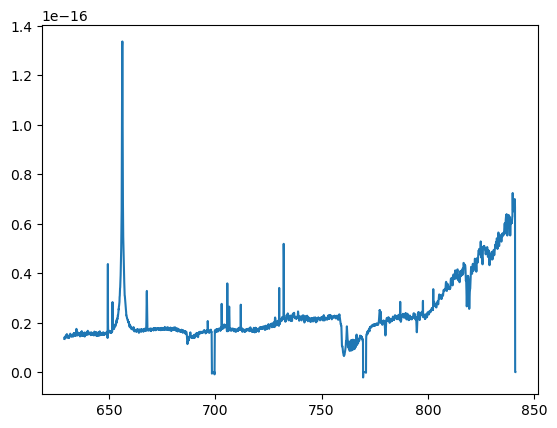

In [32]:
plt.plot(wavelength, flux_flare)

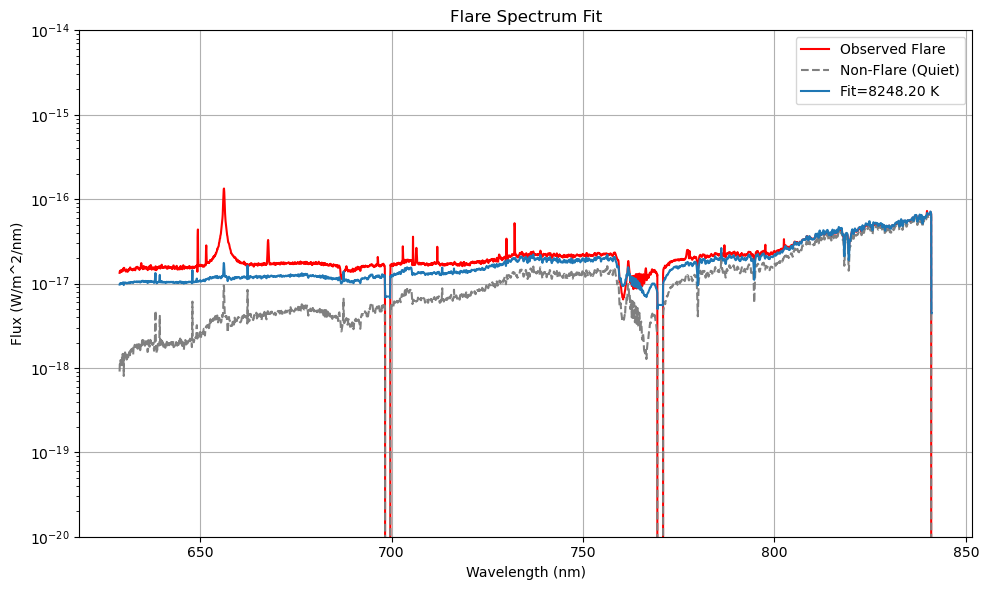

Best-fit Temperature: 8248.204807636339 ± 3.0133387528254534e-51 K
Best-fit Scale Factor: 1.0939316733552892e-22 ± 8.584198683592419e-26


In [42]:
# Mask H alpha and other spectral features
line_mask = np.ones_like(wavelength, dtype=bool)
line_mask &= ~((wavelength > 650) & (wavelength < 660))
line_mask &= ~((wavelength > 680) & (wavelength < 685))
line_mask &= ~((wavelength > 755) & (wavelength < 765))
line_mask &= ~((wavelength > 775) & (wavelength < 785))
line_mask &= ~((wavelength > 848) & (wavelength < 868)) 

# plt.ylim(0,.2e-17)
# plt.plot(wavelength[line_mask], flare_only[line_mask])
uncertainty_full = np.sqrt(variance29[flare_idx])
uncertainty = uncertainty_full[line_mask]
valid = np.isfinite(uncertainty) & (uncertainty > 0)

(popt, perr) = fit_blackbody(wavelength[line_mask][valid],
                             flare_only[line_mask][valid],
                             sigma=uncertainty[valid])    #fitting wavelength and flare_only without the indices of the flare
T_fit, scale_fit = popt
T_err, scale_err = perr

# bb_component = scale_fit * blackbody_lambda(wavelength, T_fit)
# model_flux = avg_quiet_flux + bb_component
model_flux = blackbody_lambda(wavelength, T_fit)
model_total = avg_quiet_flux + model_flux * scale_fit

plt.figure(figsize=(10, 6))

plt.semilogy(wavelength, flux_flare, label='Observed Flare', color='red')
# plt.semilogy(wavelength, model_flux * 0.25 * scale_fit, label=f'Fit: T = {T_fit:.0f} K', color='blue')
plt.semilogy(wavelength, avg_quiet_flux, label='Non-Flare (Quiet)', linestyle='--', color='gray')
plt.semilogy(wavelength, model_total, label=f'Fit={T_fit:.2f} K')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux (W/m^2/nm)')
plt.title('Flare Spectrum Fit')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.ylim(1e-20,1e-14)
plt.show()

print(f"Best-fit Temperature: {T_fit} ± {T_err} K")
print(f"Best-fit Scale Factor: {scale_fit} ± {scale_err}")


In [36]:
model_total_valid = model_flux[line_mask][valid] * scale_fit + avg_quiet_flux[line_mask][valid]
obs_flux = flux_flare[line_mask][valid]
residuals = obs_flux - model_total_valid
chi2 = np.sum((residuals / uncertainty[valid])**2)
dof = len(residuals) - 2
reduced_chi2 = chi2 / dof

print(f"Best-fit Temperature: {T_fit:.1f} ± {T_err:.3e} K")
print(f"Best-fit Scale Factor: {scale_fit:.3e} ± {scale_err:.3e}")
print(f"Chi-squared: {chi2:.2f}")
print(f"Reduced chi-squared: {reduced_chi2:.2f}")


Best-fit Temperature: 8248.2 ± 3.013e-51 K
Best-fit Scale Factor: 1.094e-22 ± 8.584e-26
Chi-squared: 837532.93
Reduced chi-squared: 327.55
